In [37]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = pd.read_csv("./10feature_cpu.csv")
col = list(map(str, data.columns))
x = data[col[:-1]]
y = data[col[-1]]

scaler = MinMaxScaler()

x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=0.5)


In [38]:
from sklearn.feature_selection import SelectKBest, f_classif

selectK = SelectKBest(score_func=f_classif, k=10)
X = selectK.fit_transform(x, y)
#print(X)
#X.plot(kind="bar", color="purple")
#temp = pd.DataFrame(selectK.fit_transform(x, y), columns=x.columns, index=x.index)
#temp.columns = ['features_name', 'importance']
#temp.sort_values("importance", ascending =False)[:10]
#temp.plot(kind="bar", color="purple")
temp = pd.DataFrame(X, columns=x.columns, index=x.index)
temp

,node_cpu_seconds_total,node_memory_Unevictable_bytes,node_schedstat_waiting_seconds_total,node_cpu_scaling_frequency_hertz,node_memory_Active_anon_bytes,node_schedstat_running_seconds_total,process_cpu_seconds_total,node_schedstat_timeslices_total,node_memory_MemFree_bytes,node_procs_running
0,0.986577,0.0,0.000365,0.000000,0.162947,0.009091,0.586957,0.032106,0.742680,0.135714
1,0.953020,0.0,0.000422,0.000156,0.160683,0.023162,0.500000,0.035856,0.745172,0.142857
2,0.906040,0.0,0.000103,0.161401,0.155379,0.010352,0.521739,0.033133,0.742182,0.142857
3,0.979866,0.0,0.000216,0.000156,0.184941,0.020652,0.608696,0.024195,0.738335,0.164286
4,0.916107,0.0,0.000639,0.000207,0.185652,0.022605,0.543478,0.030513,0.736880,0.114286
...,...,...,...,...,...,...,...,...,...,...
1394,0.983221,0.0,0.000430,0.038910,0.103758,0.024057,0.630435,0.027328,0.519902,0.128571
1395,0.996644,0.0,0.000303,0.000104,0.113526,0.007565,0.543478,0.010222,0.515039,0.150000
1396,0.929530,0.0,0.000158,0.001038,0.121806,0.021742,0.630435,0.034674,0.513643,0.100000
1397,0.909396,0.0,0.000231,0.035279,0.121806,0.002480,0.608696,0.094365,0.528493,0.107143


In [39]:
from sklearn.ensemble import ExtraTreesClassifier

etc_model = ExtraTreesClassifier()
etc_model.fit(x, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(x.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:10]

[0.31746448 0.02740444 0.07625707 0.0809074  0.03567339 0.30636405
 0.07592097 0.01724475 0.02505286 0.03771059]


,features_name,importance
0,node_cpu_seconds_total,0.317464
5,node_schedstat_running_seconds_total,0.306364
3,node_cpu_scaling_frequency_hertz,0.080907
2,node_schedstat_waiting_seconds_total,0.076257
6,process_cpu_seconds_total,0.075921
9,node_procs_running,0.037711
4,node_memory_Active_anon_bytes,0.035673
1,node_memory_Unevictable_bytes,0.027404
8,node_memory_MemFree_bytes,0.025053
7,node_schedstat_timeslices_total,0.017245


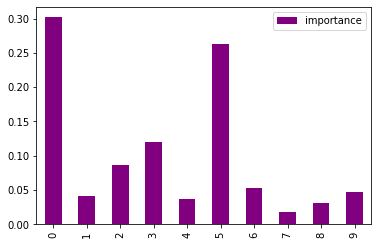

In [22]:
feature_list.plot(kind="bar", color="purple")

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 1)
fit = rfe.fit(x, y)

print("Num Features: {}".format(fit.n_features_))
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_))
print("Sort Ranking : {}".format(np.sort(fit.ranking_)))
print("Sort Ranking index num : {}".format(np.argsort(fit.ranking_)))
#print(fit.ranking_)

Num Features: 1
Selected Features: [ True False False False False False False False False False]
Feature Ranking: [ 1  4  9  5  6  2 10  7  3  8]
Sort Ranking : [ 1  2  3  4  5  6  7  8  9 10]
Sort Ranking index num : [0 5 8 1 3 4 7 9 2 6]


In [19]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', LogisticRegression())])

param_grid = [{'classifier': [SVC()], 
              'classifier__gamma': [0.01, 0.1, 1, 10, 100], 
              'classifier__C': [0.01, 0.1, 1, 10, 100]
              },

               {'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'], 
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
               },

              {'classifier': [RandomForestClassifier()],
              'classifier__max_depth': [4, 6], # max_depth: The maximum depth of the tree.
              'classifier__n_estimators': [50, 100], # n_estimators: The number of trees in the forest.
              'classifier__min_samples_split': [50, 100]
              }] # min_samples_split: The minimum number of samples required to split an internal node       
print('1')
grid = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=3)  
grid.fit(x, y)
print('2')
print(grid.best_params_)
print(grid.best_score_)

1
2
{'classifier': SVC(C=10, gamma=0.1), 'classifier__C': 10, 'classifier__gamma': 0.1}
0.99560069542581


In [20]:
col = list(map(str, data.columns))